In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
import random
from sklearn.utils import resample
import warnings 
warnings.filterwarnings('ignore')

from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
def upsample(df):
  up = df['class'].value_counts()[1]
  df_majority = df[df['class']==1]
  df_minority = df[df['class']==0]
  df_minority_upsampled = resample(df_minority, 
                                  replace=True,     # sample with replacement
                                  n_samples=up,    # to match majority class
                                  random_state=123) # reproducible results
  
  # Combine majority class with upsampled minority class
  df_upsampled = pd.concat([df_majority, df_minority_upsampled])
  
  # Display new class counts
  df=df_upsampled
  nrows=len(df['class'])
  df.index=[i for i in range(nrows)]
  return df

In [0]:
def dim_reduction(df):
  df = df.drop(['Unnamed: 0','pred','spectrometric_redshift'], axis = 1)
  temp = df['galex_objid']
  temp = temp.unique()
  corr = df.corr()
  plt.figure(figsize = (30,16))
  sns.heatmap(corr,cmap='coolwarm')
  corr_class = []
  corr_final = []
  for i in df.columns:
      corr_class.append(pointbiserialr(df['class'],df[i]))
  for i in range(len(corr_class)):
    corr_final.append(corr_class[i][0])
  columns = np.full((corr.shape[0],), True, dtype=bool)
  for i in range(corr.shape[0]):
      for j in range(i+1, corr.shape[0]):
          if corr.iloc[i,j] > 0.9 or corr.iloc[i,j] < -0.9:
              if abs(corr_final[j]) < abs(corr_final[i]) :
                  columns[j] = False
              else:
                  columns[i] = False
  selected_columns = df.columns[columns]
  data = df[selected_columns]
  return data.columns

In [0]:
def normalise(df, columns):
  nrows=len(df['class'])
  features = [col for col in df.columns if col!='class']
  for col in features:
    mean=sum(df[col])/len(df[col])
    max_val=max(df[col])
    min_val=min(df[col])
    for i in range(nrows):
      df[col][i]=(mean-df[col][i])/(max_val-min_val)
  return df

In [0]:
class kfold():
  def __init__(self,dataset,k=2):
    self.k = k
    self.splits = [[] for i in range(k)] # create k sets
    self.gen_splits(dataset)

  def gen_splits(self,dataset):
    length = len(dataset)  # Total number of columns
    available_indexes = [i for i in range(len(dataset))] #Available indexes

    for subset in range(len(self.splits)):
      for i in range(int(length/self.k)):
        number = random.choice(available_indexes)
        self.splits[subset].append(number)
        available_indexes.remove(number)

    for i in available_indexes:
        random_no =int(random.random()*self.k)
        self.splits[random_no].append(i)

  def gen_indexes(self):
    all_indexes = []
    for i in range(len(self.splits)):
      test_index = self.splits[0]
      train_index =[]
      for j in range(len(self.splits)):
        if(i!=j):
          train_index.extend(self.splits[j])
      all_indexes.append((train_index,test_index))
    return all_indexes

In [0]:
def knn(df, columns, k):
  #normalise
  df = normalise(df, columns)

  #k-fold split
  labels = df['class']
  dataset=df.drop('class',axis=1)
  number_splits=10
  kfoldobj = kfold(dataset,number_splits)
  kf=0

  for train_index,test_index in kfoldobj.gen_indexes():
    train_data,train_labels,test_data,test_data_labels = dataset.values[train_index],labels.values[train_index],dataset.values[test_index],labels.values[test_index]
    print("Fold", kf)
    dist_from_origin=[]
    nrows = len(train_data)
    for i in range(nrows):
      sum=0
      for col in range(len(train_data[0])):
        sum+=train_data[i][col]**2
      dist_from_origin.append((i, sum**0.5,train_labels[i]))
    dist_from_origin=sorted(dist_from_origin, key=lambda tup: tup[1])
    nrows_test=len(test_data)
    test_result=[]
    for t in range(nrows_test):
      sum=0
      for col in range(len(test_data[0])):
        sum+=train_data[t][col]**2
      new_point = sum**0.5
      for i in range(nrows):
        if new_point<dist_from_origin[i][1]:
          break
      i-=1
      res=[]
      kn=0
      sum=0
      z=1
      d=1
      j=0
      new_data=test_data[t]
      while i+d*z<nrows:
        sum=0
        if (i)+z*d>nrows or i==nrows-1:
          d=-1
          z+=1
        elif i+z*d<0 or i==0:
          d=1
          z+=1
        else:
          z+=(j%2)
          d=-d
        if i+d*z<nrows and i+d*z>=0:
          for col in range(len(test_data[0])):
            sum+=(new_data[col]-train_data[dist_from_origin[i+z*d][0]][col])**2
          if (dist_from_origin[i+z*d][1]<1 and sum**0.5<(dist_from_origin[i+z*d][1])**2) or (dist_from_origin[i+z*d][1]>=1 and sum**0.5<(dist_from_origin[i+z*d][1])**0.5):
            kn+=1
            res.append((sum**0.5,dist_from_origin[i+z*d][2]))
            if kn==100:
              break
          j+=1
      res=sorted(res, key = lambda tup: tup[0])
      val_0=0
      val_1=0
      for r in res[0:k]:
        if r[1]==0:
          val_0+=1/(r[0]+0.00000000000001)
        else:
          val_1+=1/(r[0]+0.00000000000001)
      if val_0>val_1:
        test_result.append((0,test_data_labels[t]))
      else:
        test_result.append((1,test_data_labels[t]))
      num_pts=len(test_result)
      count_test=0
    kf+=1
    #metrics
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for zx in range(num_pts):
      if test_result[zx][0]==1 and test_result[zx][1]==1:
        tp+=1
      elif test_result[zx][0]==1 and test_result[zx][1]==0:
        fp+=1
      elif test_result[zx][0]==0 and test_result[zx][1]==1:
        fn+=1
      elif test_result[zx][0]==0 and test_result[zx][1]==0:
        tn+=1
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    accuracy=(tp+tn)/(tp+fp+fn+tn)*100
    f1=2*(precision*recall)/(precision+recall)
    print("Recall:",recall)
    print("Precision:",precision)
    print("F1:",f1)
    print("Accuracy:",accuracy,"\n")
  '''import matplotlib.pyplot as plt# ROC curve
  from sklearn.metrics import roc_auc_score
  from sklearn.metrics import roc_curve

  y_true = list(map(lambda x:x[1],test_result))
  y_pred = list(map(lambda x:x[0],test_result))
  fpr,tpr,thresh=roc_curve(y_true,y_pred)
  plt.figure()
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic for Catalog2 k=3')
  plt.plot(fpr,tpr)
  plt.show()'''



--------Catalog 2--------
Fold 0
Recall: 0.790625
Precision: 0.9068100358422939
F1: 0.8447412353923205
Accuracy: 85.60371517027863 

Fold 1
Recall: 0.840625
Precision: 1.0
F1: 0.9134125636672326
Accuracy: 92.10526315789474 

Fold 2
Recall: 0.840625
Precision: 1.0
F1: 0.9134125636672326
Accuracy: 92.10526315789474 

Fold 3
Recall: 0.83125
Precision: 1.0
F1: 0.9078498293515359
Accuracy: 91.64086687306502 

Fold 4
Recall: 0.840625
Precision: 1.0
F1: 0.9134125636672326
Accuracy: 92.10526315789474 

Fold 5
Recall: 0.85
Precision: 1.0
F1: 0.9189189189189189
Accuracy: 92.56965944272446 

Fold 6
Recall: 0.85
Precision: 1.0
F1: 0.9189189189189189
Accuracy: 92.56965944272446 

Fold 7
Recall: 0.828125
Precision: 1.0
F1: 0.905982905982906
Accuracy: 91.48606811145511 

Fold 8
Recall: 0.84375
Precision: 1.0
F1: 0.9152542372881356
Accuracy: 92.26006191950464 

Fold 9
Recall: 0.834375
Precision: 1.0
F1: 0.9097103918228279
Accuracy: 91.79566563467493 



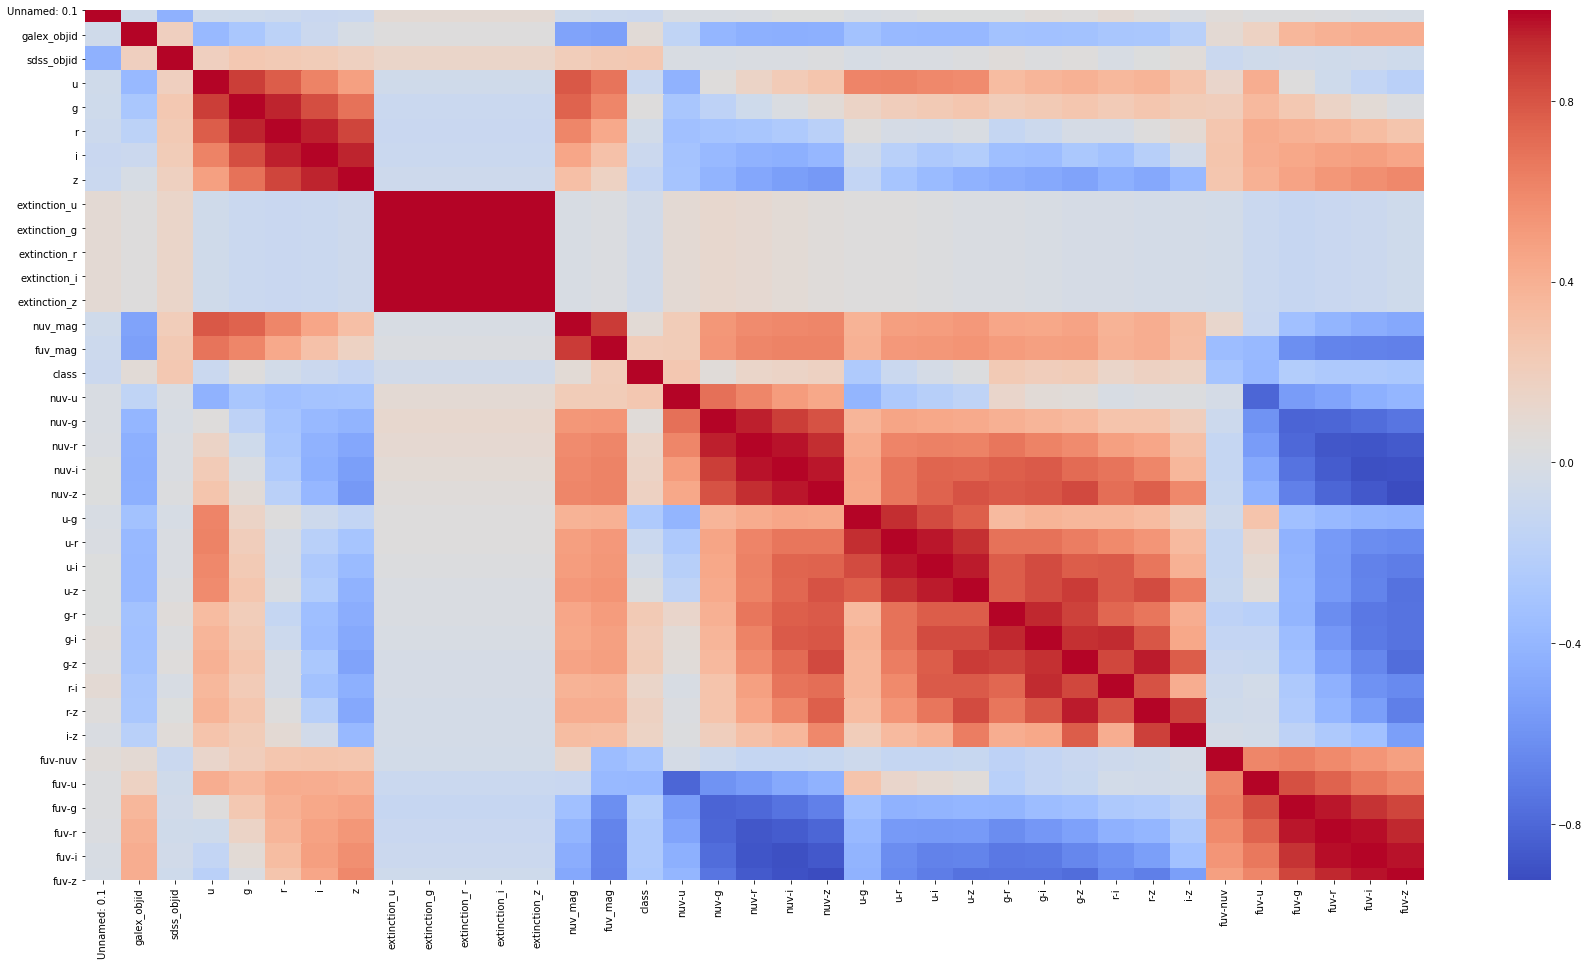

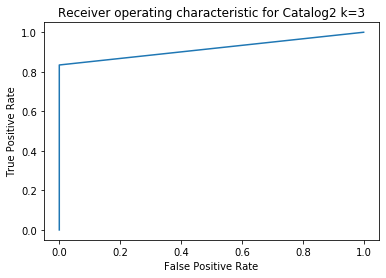

In [0]:
cat1 = upsample(pd.read_csv('/gdrive/My Drive/may-this-be-the-last-time/catalog1/cat1.csv'))
cat2 = upsample(pd.read_csv('/gdrive/My Drive/may-this-be-the-last-time/catalog2/cat2.csv'))
cat3 = upsample(pd.read_csv('/gdrive/My Drive/may-this-be-the-last-time/catalog3/cat3.csv'))
#cat4 = upsample(pd.read_csv('/gdrive/My Drive/may-this-be-the-last-time/catalog4/cat4.csv'))
k = 5
print('--------Catalog 1--------')
knn(cat1, dim_reduction(cat1), k)
print('\n\n--------Catalog 2--------')
knn(cat2, dim_reduction(cat2), k)
print('\n\n--------Catalog 3--------')
knn(cat3, dim_reduction(cat3), k)
#print('\n\n--------Catalog 4--------')
#knn(cat4, dim_reduction(cat4), k)